In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(phyloseq)
library(plyr)
library(dplyr); library(tidyr)
library(ggplot2)
library(rwantshue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [6]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [40]:
%%R
mdf = psmelt(physeq)

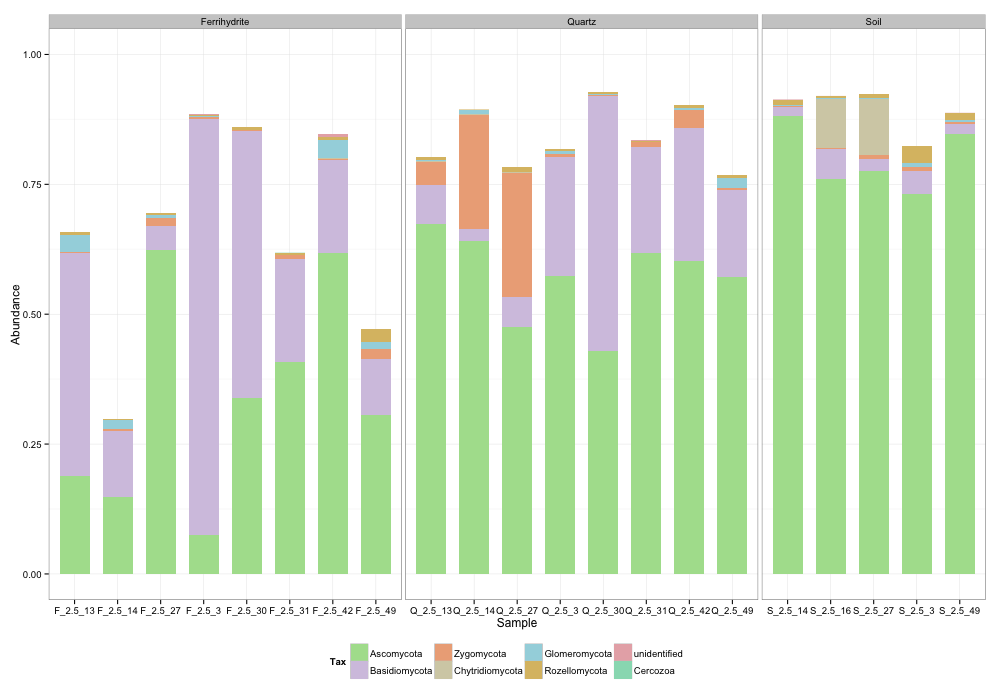

In [33]:
%%R -w 1000 -h 700

cutoff = 0.0001
totabund = 3000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, Phylum, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Month == 2.5) %>%
    filter(Trtmt != "Kaolinite") %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    #axis.text.x = element_blank(), 
    legend.position="bottom")

p

This shows the relative abundance of each taxon, out of the total pool in each sample.  
We can see immediately that Glomerales are relatively enriched compared to the soil.

In [26]:
%%R
OTUabund = 0.001
d.plot = mdf %>%
    group_by(Sample) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, OTU, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Month == 2.5) %>%
    filter(Trtmt == "Ferrihydrite") %>%
    filter(Abundance > OTUabund)%>%
    arrange(Trtmt)

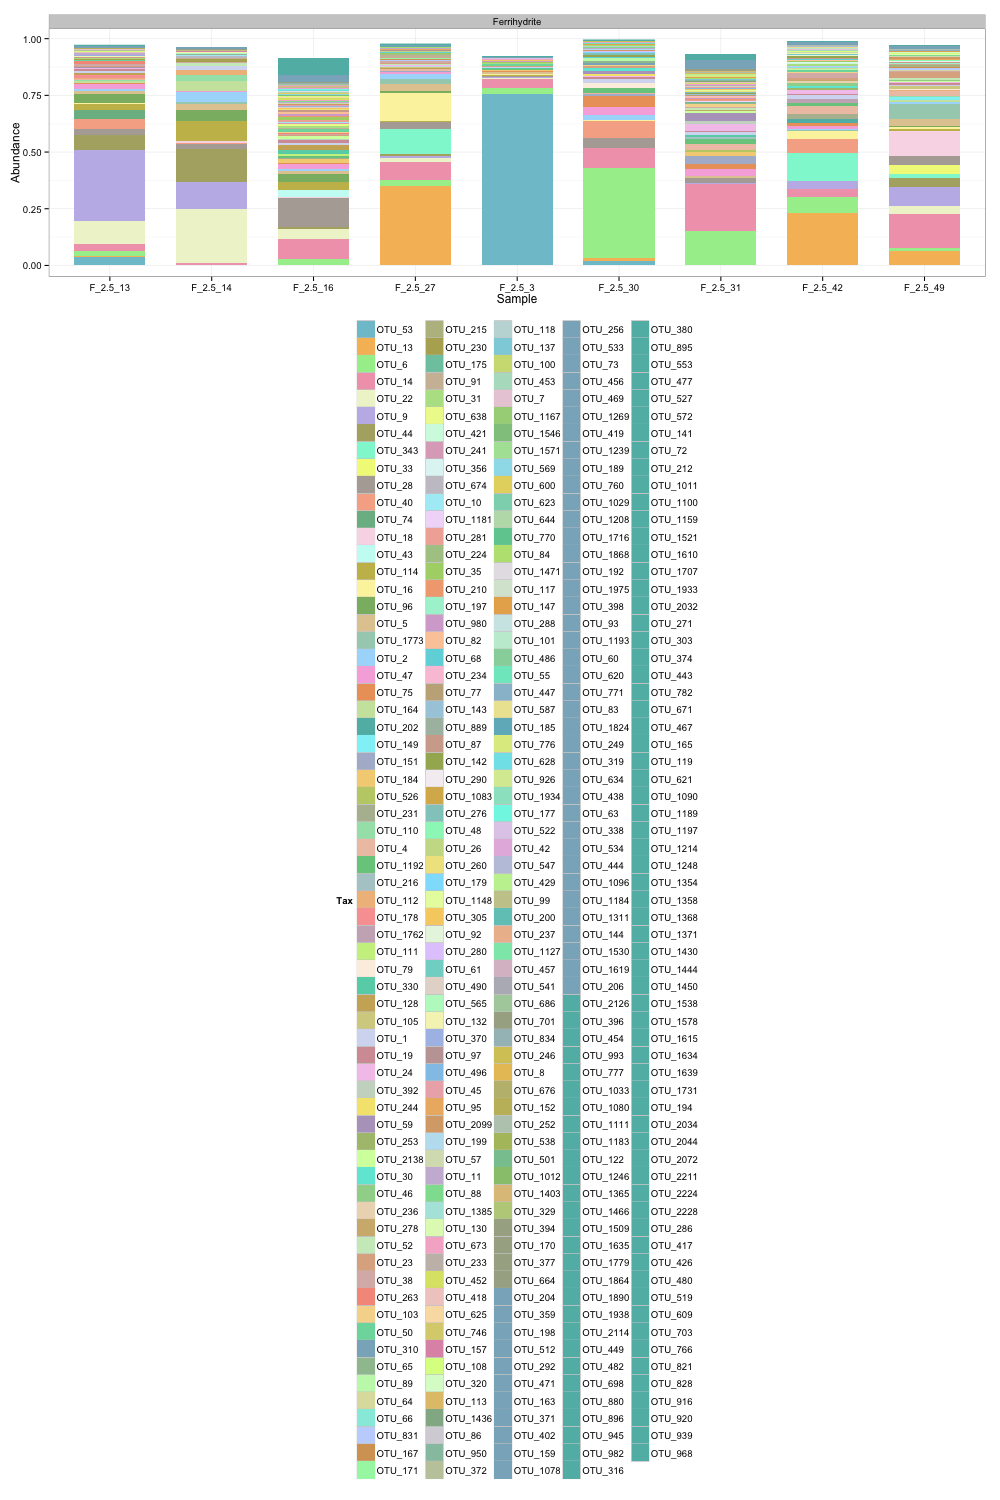

In [27]:
%%R -w 1000 -h 1500

d.plot = d.plot

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors, guide=FALSE)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    #axis.text.x = element_blank(), 
    legend.position="bottom")

p

In [172]:
%%R
d.plot = mdf %>%
    filter(Phylum=="Glomeromycota")%>%
    filter(Month == 2.5) %>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    group_by(Trtmt,Month) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Order,Family,Genus,Species, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Trtmt)
head(d.plot)

Source: local data frame [6 x 7]
Groups: Order, Family, Genus, Species, Trtmt

            Order           Family        Genus             Species
1 Archaeosporales Archaeosporaceae unidentified Archaeosporaceae sp
2 Archaeosporales Archaeosporaceae unidentified Archaeosporaceae sp
3 Archaeosporales Archaeosporaceae unidentified Archaeosporaceae sp
4 Archaeosporales     unidentified unidentified  Archaeosporales sp
5 Archaeosporales     unidentified unidentified  Archaeosporales sp
6 Archaeosporales     unidentified unidentified  Archaeosporales sp
Variables not shown: Trtmt (chr), Month (dbl), Abundance (dbl)


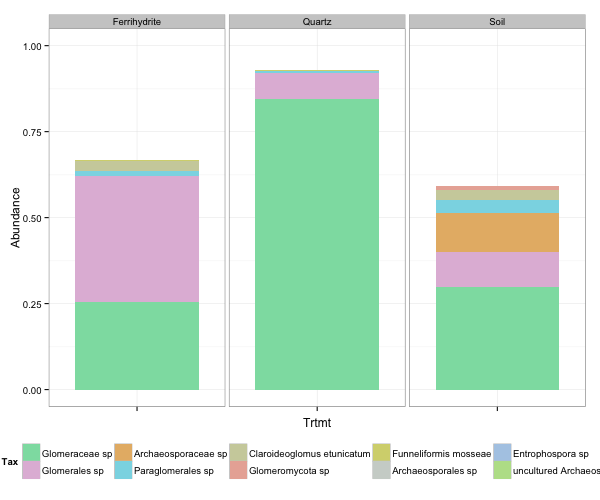

In [233]:
%%R -w 600 -h 500

d.plot = mdf %>%
    filter(Phylum=="Glomeromycota")%>%
    filter(Month == 2.5) %>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    group_by(Trtmt,Month) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Species, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank(), legend.position="bottom")

p

In [240]:
%%R
d.plot = mdf %>%
    filter(Phylum=="Glomeromycota")%>%
    filter(Month == 2.5) %>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    group_by(Trtmt,Month) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Order,Family,Genus,Species, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Trtmt)
d.plot[21:40,]

Source: local data frame [20 x 7]
Groups: Order, Family, Genus, Species, Trtmt

             Order               Family           Genus
1  Diversisporales                   NA              NA
2       Glomerales Claroideoglomeraceae Claroideoglomus
3       Glomerales Claroideoglomeraceae Claroideoglomus
4       Glomerales Claroideoglomeraceae Claroideoglomus
5       Glomerales Claroideoglomeraceae              NA
6       Glomerales Claroideoglomeraceae              NA
7       Glomerales Claroideoglomeraceae              NA
8       Glomerales          Glomeraceae   Funneliformis
9       Glomerales          Glomeraceae   Funneliformis
10      Glomerales          Glomeraceae   Funneliformis
11      Glomerales          Glomeraceae    unidentified
12      Glomerales          Glomeraceae    unidentified
13      Glomerales          Glomeraceae    unidentified
14      Glomerales          Glomeraceae              NA
15      Glomerales          Glomeraceae              NA
16      Glomerales      